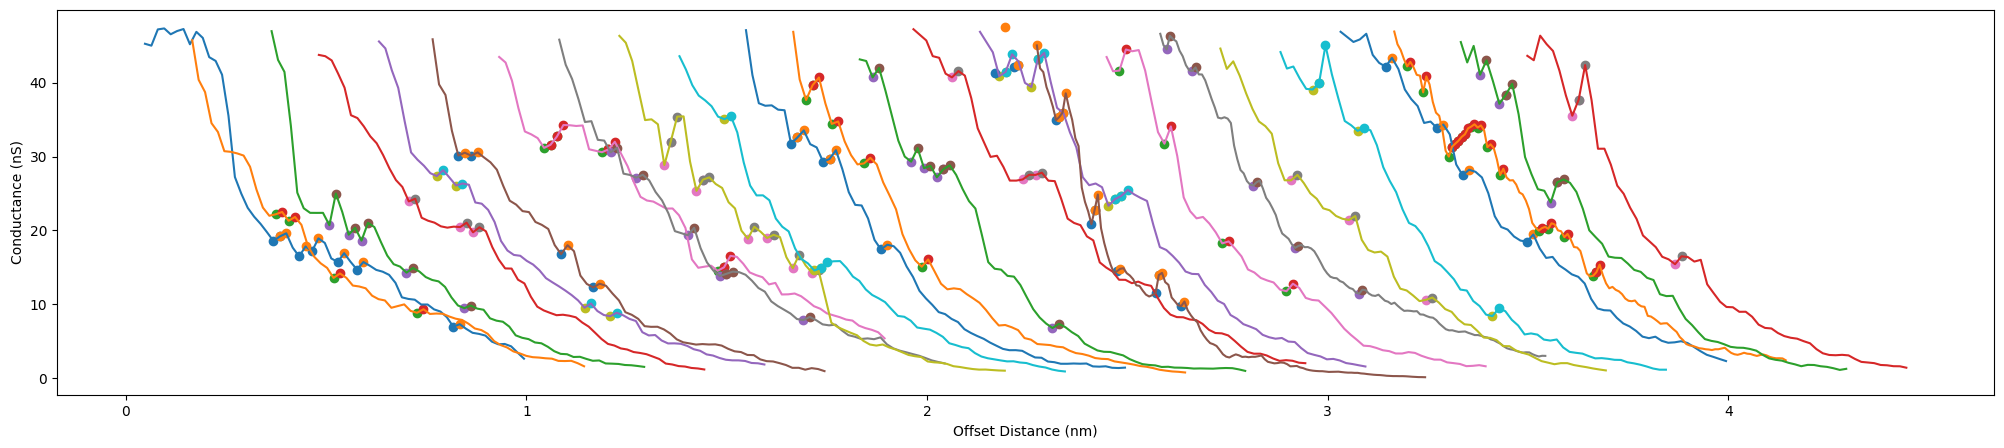

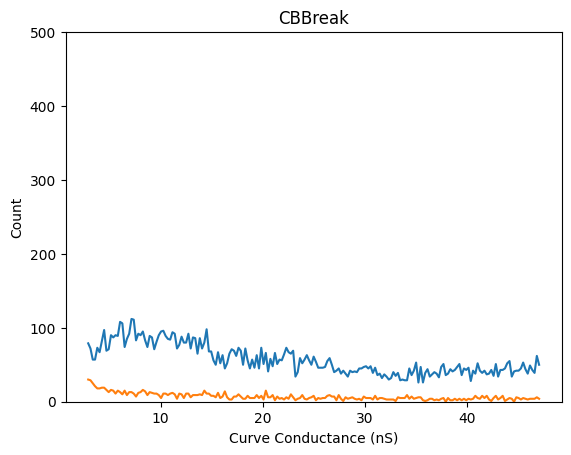

n Filtered
0.12480280455740578
11410 1424


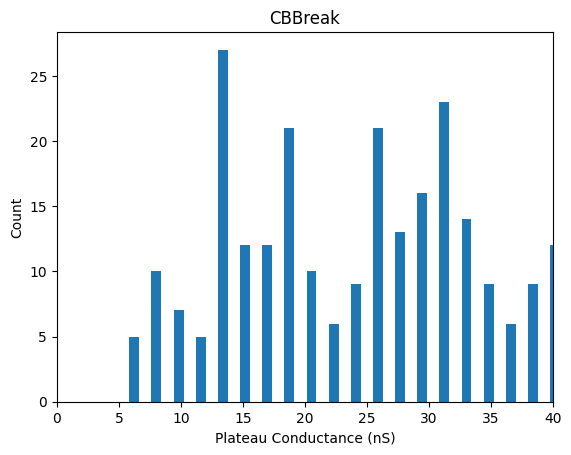

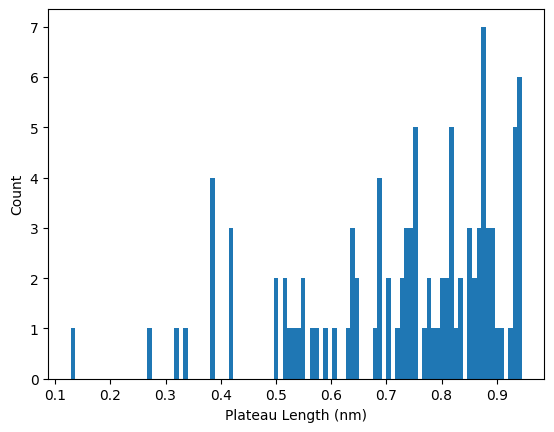

In [8]:
records={}
folders=[
    r"\\BIOD1633\Data\PEG4-Biotin\20230208_SubPeg4-Biotin_SA_TipBiotincyst\CBBreak",
]

showLines=True
for sDir in folders:
    dataFiles = glob( sDir+ r"\*.mi", recursive=False)
    sName = os.path.basename(sDir)

 
    curves2,binsAllData,valuesAllData=LoadMICurves(dataFiles)
    bins,valuesC,valuesAll,binAll,valuesJumps,binJ,distances=GetJumps(curves2,showLines)


    b=bins[:-1]

    plt.plot(binAll[1:-1],valuesAll[1:])
    plt.plot(b[1:], valuesC[1:])
    plt.ylim([0,500])
    plt.title(sName)
    plt.ylabel('Count')
    plt.xlabel(r'Curve Conductance (nS)')
    plt.show()

    print('n Filtered')
    print(np.sum(valuesC)/np.sum(valuesAll))
    print(np.sum(valuesAll),np.sum(valuesC))
    plt.bar(binJ[1:-1], valuesJumps[1:])
    plt.title(sName)
    plt.xlim([0,40])
    plt.ylabel('Count')
    plt.xlabel(r'Plateau Conductance (nS)')
    plt.show()


    plt.hist(distances,bins=100)
    plt.ylabel('Count')
    plt.xlabel(r'Plateau Length (nm)')
    plt.show()

    records[sName]={'binJ':binJ,'valuesJumps':valuesJumps,'b':b,'valuesC':valuesC, 'file':sDir,'samples':len(dataFiles)}

\\BIOD1633\Data\PEG4-Biotin\20230208_SubPeg4-Biotin_SA_TipBiotincyst\CBBreak\3758759998_35_break.tdms


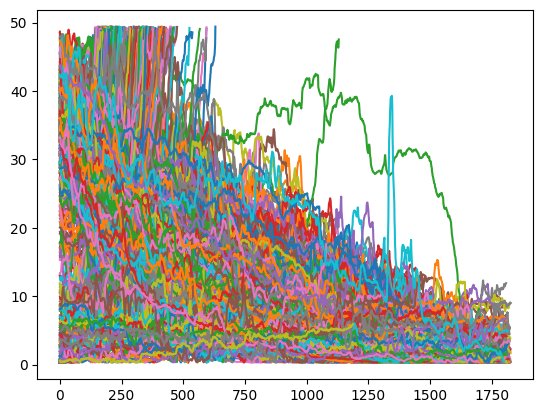

In [12]:



folders=[
    r"\\BIOD1633\Data\PEG4-Biotin\20230208_SubPeg4-Biotin_SA_TipBiotincyst\CBBreak"
   #  r"\\BIOD1633\Data\30bp DNA\2023_02_06_30bpDNA_PBS_1uMDNA_added\.2V\5nm Withdraw"
]

from lmfit import Parameters, minimize
from lmfit.printfuncs import report_fit
from lmfit import Model


showLines=True
for sDir in folders:
    dataFiles = glob( sDir+ r"\*.tdms", recursive=False)
    sName = os.path.basename(sDir)
    dataFiles = [x for x in dataFiles if 'monitor' not in x.lower()]
 
    ####################################
    curves=[]

    print(dataFiles[100])
    cc=0
    bins=[]
    values=[]
    diffBins=np.linspace(0,100,1000)
    diffValues=np.zeros(len(diffBins)-1)
    curveValues=np.zeros(len(diffBins)-1)
    
    for file in dataFiles:
        times,currents,bias=loadTDMSCurve(file)
        #plt.plot(times,currents)

        if np.max(currents)>9 or np.min(currents)>-9:
            continue
        if (np.min(bias)==-.2 or np.min(bias)==-.5):
            cuts=CutTDMS(times,currents,bias,.03)
            for cut in cuts:
                t,c=cut['times'],cut['conductance']
                
                initParams =[np.max(c),10000,0, np.min(c),.0005]
                bounds=( (initParams[0]*.75,initParams[0]*1.5), #exp amp
                         (initParams[1]*2,initParams[1]*.5),    #alpha
                         (-.01,.01), #timeoffset
                         (0,initParams[3]*3),    #offset
                         (0,initParams[3]*3)    #A/x
                       )
                
                fit_params = Parameters()
                fit_params.add('amp', value=initParams[0], min=bounds[0][0], max=bounds[0][1])
                fit_params.add('alpha', value=initParams[1], min=bounds[1][0], max=bounds[1][1])
                fit_params.add('timeOffset', value=initParams[2], min=bounds[2][0], max=bounds[2][1])
                fit_params.add('offset', value=initParams[3], min=bounds[3][0], max=bounds[3][1])
                fit_params.add('amp2', value=initParams[4], min=bounds[4][0], max=bounds[4][1])
                
                def residual(pars, x, data=None):  
                    v=pars['amp']* np.exp(-1*pars['alpha'] * (x-pars['timeOffset']))+pars['offset']
                    v+=pars['amp2']/(x+.0001)
                    if data is None:
                        return v
                    return  data-v

                def Tunnel(x, amp,alpha,timeOffset,offset,amp2 ):  
                    v=amp* np.exp(-1*alpha * (x-timeOffset))+offset
                    v+=amp2/(x+.0001)
                    return v

                bmodel = Model(Tunnel)

                

                result = bmodel.fit(c, fit_params, x=t,weights=(t+.001)**3)
                
                dC=c-result.best_fit
                error=np.mean(np.abs(dC))
                
                #fittedParameters, pcov = curve_fit(func, t, c, initParams,bounds=bounds)
                
                    
                if error>.25:
                    dC= c- bmodel.eval(fit_params, x=t) 
                    dC=dC[t>.002]
                    dC=dC[dC>.3]
                    if True and error>2:
                        #print(error)
                        #plt.plot( c)#10**dC)
                        plt.plot( dC)
                        #plt.semilogy(t*.04, result.best_fit)
                        #plt.plot(t*.04,c)
                        #plt.ylim([np.min(dC),np.max(dC)])
                        #plt.show()
                        v,_=np.histogram( dC ,bins=diffBins)
                        diffValues+=v
                    
                    if len(bins)==0:
                        values,bins=np.histogram(np.log10(c),bins=300)
                    else:
                        v,_=np.histogram(np.log10(c),bins=bins)
                        values+=v
                    
                    
                    
                     
                    dC=c-bmodel.eval(result.params, x=t)
                    v,_=np.histogram( dC  ,bins=diffBins)
                    curveValues+=v
                    
                    
            cc+=1
            #if cc>80:
            #    basdf()
        
 

NameError: name 'e_dBins' is not defined

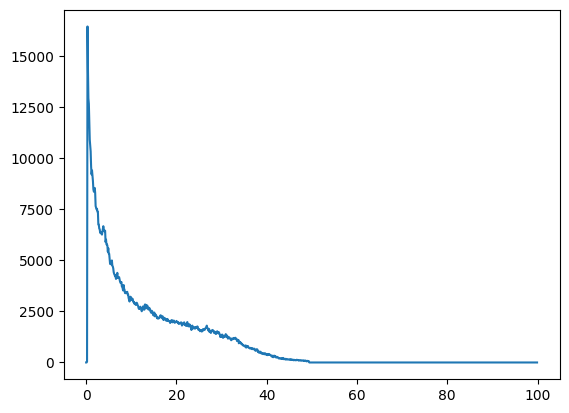

In [13]:
#cnBins,cnValues=bins[:-1],values

c_dBins,c_dValues=diffBins[:-1],diffValues
c_dBins,c_cValues=diffBins[:-1],curveValues
cbins,cvalues=bins[:-1],values

#e_dBins,e_dValues=diffBins[:-1],diffValues
#e_dBins,e_cValues=diffBins[:-1],curveValues
#ebins,evalues=bins[:-1],values

#plt.semilogy(diffBins[:-1],diffValues,label='Control')
plt.plot( c_dBins,c_dValues,label='Control')
plt.plot( e_dBins,e_dValues,label='dsDNA 30bp')
plt.xlim([0,50])
plt.ylim([0,2500])
 
plt.title('diffValue')
plt.legend()
plt.show()


plt.semilogx(c_dBins,c_cValues,label='Control')
plt.semilogx(e_dBins,e_cValues,label='dsDNA 30bp')
plt.title('curveValues')
plt.legend()
plt.show()

plt.semilogx(10**cbins,cvalues,label='bare')
plt.semilogx(10**ebins,evalues, label='dsDNA')
plt.xlim([.01,80])
plt.ylim([0,100000])
plt.legend()
plt.show()